In [1]:
import json
from glob import glob

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()


class DSet(Dataset):

    def __init__(self, samples, step=100):
        self.data = np.zeros((len(samples), step), dtype=np.float32)
        self.target = np.zeros(len(samples), dtype=np.float32)
        raw_data = np.load('data/prop_graph.npz')
        for i, sample in enumerate(samples):
            span = raw_data[sample][:, 0]
            volumn = np.log10(span + 1) / 8.1 * step
            for item in volumn.astype(int):
                self.data[i][item] += 1
            if 'rumor' in sample:
                self.target[i] = 1

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


class CNN(nn.Module):

    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, 3, padding=1)
        self.fc1 = nn.Linear(input_size // 4 * 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.dropout(x.view(x.size(0), -1), training=self.training)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)


class RNN(nn.Module):

    def __init__(self, input_size, hidden_size=64, bidirectional=True):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_directions = 2 if bidirectional else 1
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.n_directions, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1, self.input_size)
        h0 = self._init_hidden_state(x.size(0))
        x, hn = self.rnn(x, h0)
        x = self.fc(x[:, -1, :])
        return F.sigmoid(x)

    def _init_hidden_state(self, batch_size):
        h0 = torch.zeros(self.n_directions, batch_size, self.hidden_size)
        if use_cuda:
            h0 = h0.cuda()
        return Variable(h0)


class CombinedNet(nn.Module):

    def __init__(self, cnn_input_size, rnn_input_size, hidden_size=64):
        super(CombinedNet, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_input_size = rnn_input_size
        self.rnn = nn.GRU(rnn_input_size, hidden_size, batch_first=True, bidirectional=True, dropout=0.5)
        self.conv1 = nn.Conv1d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, 3, padding=1)
        self.fc_dim = cnn_input_size // 4 * 16 + hidden_size * 2
        self.fc = nn.Linear(self.fc_dim, 1)

    def forward(self, x):
        rx = x.view(x.size(0), -1, self.rnn_input_size)
        cx = x.view(x.size(0), 1, -1)
        h0 = self._init_hidden_state(rx.size(0))
        rx, hn = self.rnn(rx, h0)
        cx = F.relu(F.max_pool1d(self.conv1(cx), 2))
        cx = F.relu(F.max_pool1d(self.conv2(cx), 2))
        rcx = torch.cat((rx[:, -1, :].view(x.size(0), -1), cx.view(x.size(0), -1)), dim=1)
        out = self.fc(F.dropout(rcx, training=self.training))
        return F.sigmoid(out)

    def _init_hidden_state(self, batch_size):
        h0 = torch.zeros(2, batch_size, self.hidden_size)
        if use_cuda:
            h0 = h0.cuda()
        return Variable(h0)

In [41]:
def train(model, n_epoch=10, lr=0.05):

    if use_cuda:
        model.cuda()
    criterion = nn.BCELoss()
    optimizer = optim.RMSprop(model.parameters())
#     optimizer = optim.SGD(model.parameters(), lr=lr)

    print(f'training {model.__class__.__name__} ...')
    acc_max = 0.0
    record = {x: list() for x in ['tr_loss', 'tr_acc', 'val_loss', 'val_acc', 'predict']}
    for epoch in range(n_epoch):
#         print(f'Epoch {(epoch + 1):02d}')
        model.train()
        tr_loss, tr_acc = 0.0, 0.0
        for data, target in train_loader:
            target = target.view(target.size(0), 1)
            optimizer.zero_grad()
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            tr_loss += loss.data[0] * data.size(0)
            pred = torch.sign(output.data - 0.5).clamp(min=0)
            tr_acc += pred.eq(target.data).cpu().sum()
        tr_loss /= len(train_loader.dataset)
        tr_acc = tr_acc / len(train_loader.dataset)
        record['tr_loss'].append(tr_loss)
        record['tr_acc'].append(tr_acc)
#         print(f'tr_loss {tr_loss:.6f} | tr_acc {tr_acc*100:.2f}%')

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        record['predict'] = []
        for data, target in test_loader:
            target = target.view(target.size(0), 1)
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.data[0] * data.size(0)
            pred = torch.sign(output.data - 0.5).clamp(min=0)
            val_acc += pred.eq(target.data).cpu().sum()
            record['predict'].append(output.data.numpy())
        val_loss /= len(test_loader.dataset)
        val_acc = val_acc / len(test_loader.dataset)
        record['val_loss'].append(val_loss)
        record['val_acc'].append(val_acc)
#         print(f'val_loss {val_loss:.6f} | val_acc {val_acc*100:.2f}%')
        if record['val_acc'][-1] > acc_max:
            acc_max = record['val_acc'][-1]
            record['final'] = np.vstack(record['predict']).reshape(-1)
    return record

In [35]:
def loss_curve(rec, name, ep=100):
    
    plt.figure(figsize=(10, 5))
    lw = 2
    plt.xlim([1, ep])
    plt.ylim([0.0, 1.2])
#     plt.xlabel('Epoches')
#     plt.ylabel('Binary Cross Entropy Loss')
    plt.plot(range(1, 101), rec['tr_loss'], 'b--', label='Training Loss')
    plt.plot(range(1, 101), rec['val_loss'], 'r-', label='Validation Loss')
#     plt.legend(loc='upper right')
    plt.savefig(f'{name}.png', dpi=200)

In [3]:
samples = glob('rumor/*.json') + glob('truth/*.json')
train_data, test_data = train_test_split(samples, test_size=0.2, random_state=42)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(DSet(train_data), batch_size=128, shuffle=True, **kwargs)
test_loader = DataLoader(DSet(test_data), batch_size=128, **kwargs)

In [4]:
target = []
for x, y in test_loader:
    target.append(y.numpy())

In [5]:
def census(output, target):

    from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

    fpr, tpr, _ = roc_curve(target, output)
    auc = roc_auc_score(target, output)
    output[output < 0.5] = 0
    output[output > 0.4] = 1
    rp = precision_score(target, output, pos_label=1)
    rr = recall_score(target, output, pos_label=1)
    rf = f1_score(target, output, pos_label=1)
    np = precision_score(target, output, pos_label=0)
    nr = recall_score(target, output, pos_label=0)
    nf = f1_score(target, output, pos_label=0)
    acc = accuracy_score(target, output)
    print(f'acc: {acc:.3f}\nrp: {rp:.3f}\nrr: {rr:.3f}\nrf: {rf:.3f}')
    print(f'np: {np:.3f}\nnr: {nr:.3f}\nnf: {nf:.3f}')
    return {'fpr': fpr, 'tpr': tpr, 'auc': auc}

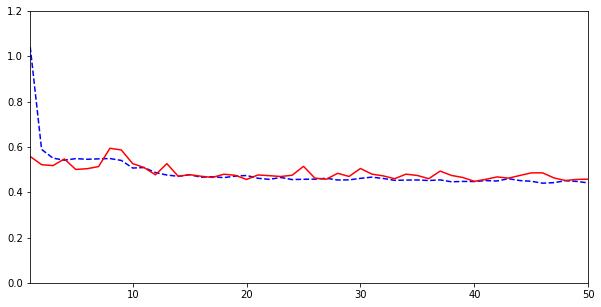

In [28]:
loss_curve(rec, 'cnn-volume')

In [42]:
rnnv = train(RNN(10))

training RNN ...
Epoch 01
tr_loss 0.696824 | tr_acc 61.75%
val_loss 0.531483 | val_acc 75.03%
Epoch 02
tr_loss 0.448894 | tr_acc 80.51%
val_loss 0.485951 | val_acc 76.53%
Epoch 03
tr_loss 0.433233 | tr_acc 80.76%
val_loss 0.456503 | val_acc 79.74%
Epoch 04
tr_loss 0.407065 | tr_acc 82.39%
val_loss 0.469538 | val_acc 77.81%
Epoch 05
tr_loss 0.397627 | tr_acc 83.01%
val_loss 0.510147 | val_acc 79.74%
Epoch 06
tr_loss 0.376321 | tr_acc 83.57%
val_loss 0.494470 | val_acc 78.78%
Epoch 07
tr_loss 0.369693 | tr_acc 84.35%
val_loss 0.642485 | val_acc 74.38%
Epoch 08
tr_loss 0.351896 | tr_acc 84.72%
val_loss 0.478427 | val_acc 80.71%
Epoch 09
tr_loss 0.335007 | tr_acc 85.34%
val_loss 0.475093 | val_acc 79.21%
Epoch 10
tr_loss 0.303150 | tr_acc 87.32%
val_loss 0.550149 | val_acc 79.96%


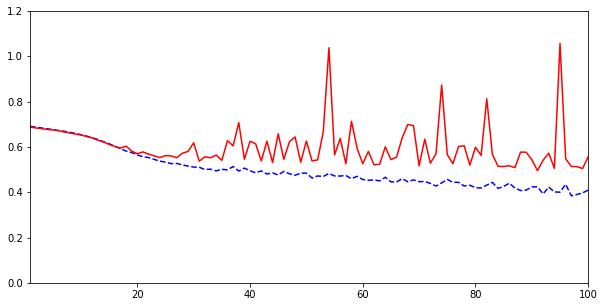

In [37]:
loss_curve(rnnv, 'rnn-volume')

In [32]:
cnnv = train(CNN(100))

training CNN ...


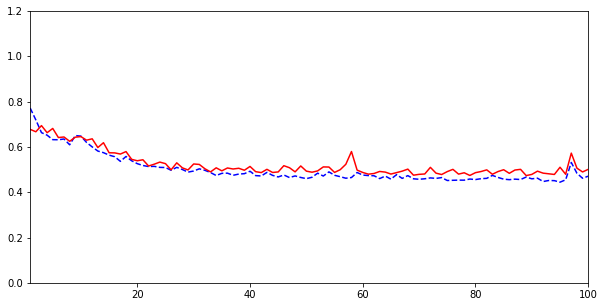

In [39]:
loss_curve(cnnv, 'cnn-volume')

In [9]:
cnndic = census(cnnv['final'], np.hstack(target).astype(int))

acc: 0.806
rp: 0.827
rr: 0.784
rf: 0.805
np: 0.786
nr: 0.829
nf: 0.807


In [10]:
rnndic = census(rnnv['final'], np.hstack(target).astype(int))

acc: 0.779
rp: 0.800
rr: 0.757
rf: 0.778
np: 0.759
nr: 0.803
nf: 0.780


In [11]:
np.savez('data/rnnv.npz', **rnndic)
np.savez('data/cnnv.npz', **cnndic)

In [17]:
rnnv = rnndic
cnnv = cnndic
rnnt, cnnt = {}, {}
tmpc = np.load('data/rnnt.npz')
tmpr = np.load('data/cnnt.npz')
for item in ['tpr', 'fpr', 'auc']:
    rnnt[item] = tmpr[item]
    cnnt[item] = tmpc[item]

In [18]:
rnnv['name'] = 'rnnv'
cnnv['name'] = 'cnnv'
rnnt['name'] = 'rnnt'
cnnt['name'] = 'cnnt'

In [29]:
def draw_roc(rec):
    mark = ['y-', 'g-', 'r-', 'c-']
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
    for item, mk in zip(rec, mark):
#         nn = census(item['final'], np.hstack(target).astype(int))
        plt.plot(item['fpr'], item['tpr'], mk, lw=2)
        print(item['name'], item['auc'], mk)
#     plt.legend(loc="lower right")
    plt.savefig('roc-single.png', dpi=200)

rnnv 0.8375721799257052 y-
cnnv 0.8687359777851337 g-
rnnt 0.9308635845378647 r-
cnnt 0.9268546103203501 c-


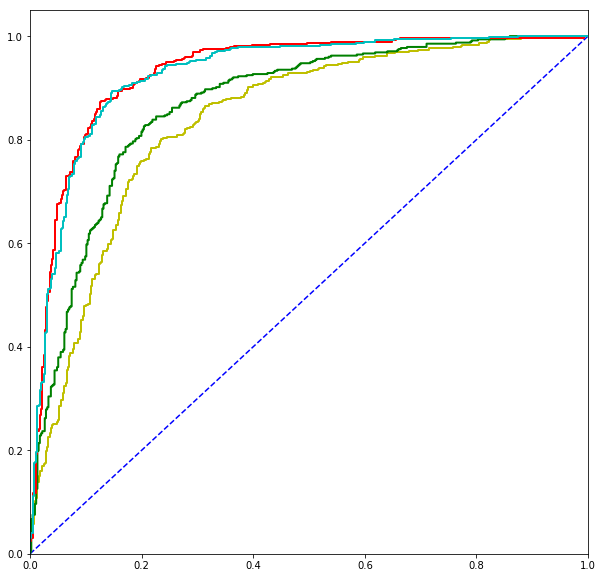

In [30]:
draw_roc([rnnv, cnnv, rnnt, cnnt])

In [33]:
len(rnnv)

6

In [34]:
dic = {'rnnv': rnnv['final'], 'cnnv': cnnv['final']}
np.savez('data/pred.npz', **dic)

In [35]:
from sklearn.model_selection import KFold

In [39]:
kf = KFold(n_splits=5, random_state=42)
train_data = np.array(train_data)

In [48]:
class DSet_(Dataset):

    def __init__(self, samples, step=100):
        self.data = np.zeros((len(samples), step), dtype=np.float32)
        self.target = np.zeros(len(samples), dtype=np.float32)
        raw_data = np.load('data/prop_graph.npz')
        for i, sample in enumerate(samples):
            span = raw_data[sample][:, 0]
            volumn = np.log10(span + 1) / 8.1 * step
            for item in volumn.astype(int):
                self.data[i][item] += 1
            if 'rumor' in sample:
                self.target[i] = 1
    
    def get_tensor(self):
        return torch.from_numpy(self.data)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [53]:
rnnv_stk = np.empty((len(train_data)))
rnnv_rec = []
for x, y in kf.split(train_data):
    train_loader = DataLoader(DSet(train_data[x]), batch_size=128, shuffle=True)
    val_data = DSet_(train_data[y]).get_tensor()
    model = RNN(10)
    rnnv_rec.append(train(model, n_epoch=5)['final'])
    rnnv_stk[y] = model(Variable(val_data, volatile=True)).data.numpy().reshape(-1)
rnnv_rec = np.mean(rnnv_rec, axis=0)

training RNN ...
Epoch 01
tr_loss 0.725629 | tr_acc 57.84%
val_loss 0.632620 | val_acc 63.56%
Epoch 02
tr_loss 0.511998 | tr_acc 76.88%
val_loss 0.499620 | val_acc 77.92%
Epoch 03
tr_loss 0.444734 | tr_acc 80.80%
val_loss 0.522580 | val_acc 77.38%
Epoch 04
tr_loss 0.432332 | tr_acc 81.27%
val_loss 0.466868 | val_acc 78.99%
Epoch 05
tr_loss 0.408658 | tr_acc 82.94%
val_loss 0.454398 | val_acc 79.21%
training RNN ...
Epoch 01
tr_loss 0.737987 | tr_acc 58.09%
val_loss 0.565295 | val_acc 75.03%
Epoch 02
tr_loss 0.481721 | tr_acc 78.99%
val_loss 0.511271 | val_acc 77.28%
Epoch 03
tr_loss 0.447844 | tr_acc 80.47%
val_loss 0.485560 | val_acc 78.24%
Epoch 04
tr_loss 0.408611 | tr_acc 82.41%
val_loss 0.580781 | val_acc 71.70%
Epoch 05
tr_loss 0.400953 | tr_acc 83.22%
val_loss 0.469805 | val_acc 78.99%
training RNN ...
Epoch 01
tr_loss 0.746944 | tr_acc 61.24%
val_loss 0.488491 | val_acc 79.21%
Epoch 02
tr_loss 0.477607 | tr_acc 79.80%
val_loss 0.466322 | val_acc 79.42%
Epoch 03
tr_loss 0.435310

In [55]:
cnnv_stk = np.empty((len(train_data)))
cnnv_rec = []
for x, y in kf.split(train_data):
    train_loader = DataLoader(DSet(train_data[x]), batch_size=128, shuffle=True)
    val_data = DSet_(train_data[y]).get_tensor()
    model = CNN(100)
    cnnv_rec.append(train(model, n_epoch=10)['final'])
    cnnv_stk[y] = model(Variable(val_data, volatile=True)).data.numpy().reshape(-1)
cnnv_rec = np.mean(cnnv_rec, axis=0)

training CNN ...
Epoch 01
tr_loss 1.975338 | tr_acc 63.91%
val_loss 0.615067 | val_acc 72.99%
Epoch 02
tr_loss 0.614536 | tr_acc 72.99%
val_loss 0.585100 | val_acc 68.49%
Epoch 03
tr_loss 0.560223 | tr_acc 75.13%
val_loss 0.508879 | val_acc 77.28%
Epoch 04
tr_loss 0.524926 | tr_acc 76.41%
val_loss 0.597008 | val_acc 72.67%
Epoch 05
tr_loss 0.510724 | tr_acc 77.51%
val_loss 0.490379 | val_acc 78.89%
Epoch 06
tr_loss 0.505668 | tr_acc 77.75%
val_loss 0.508085 | val_acc 78.24%
Epoch 07
tr_loss 0.494293 | tr_acc 79.22%
val_loss 0.521495 | val_acc 77.92%
Epoch 08
tr_loss 0.479658 | tr_acc 79.26%
val_loss 0.500217 | val_acc 80.06%
Epoch 09
tr_loss 0.476616 | tr_acc 78.82%
val_loss 0.496889 | val_acc 78.46%
Epoch 10
tr_loss 0.475590 | tr_acc 79.22%
val_loss 0.508904 | val_acc 79.85%
training CNN ...
Epoch 01
tr_loss 1.297943 | tr_acc 53.77%
val_loss 0.678568 | val_acc 55.41%
Epoch 02
tr_loss 0.660175 | tr_acc 62.81%
val_loss 0.605088 | val_acc 72.78%
Epoch 03
tr_loss 0.574351 | tr_acc 73.90%


In [56]:
cnnv_stk

array([0.17315637, 0.45348802, 0.84076959, ..., 0.23711844, 0.78286499,
       0.8722415 ])

In [57]:
rnnv_stk

array([0.41992238, 0.63247788, 0.94782984, ..., 0.109777  , 0.47246635,
       0.90140796])

In [60]:
np.savez('data/stkv.npz', cnnv=cnnv_stk, rnnv=rnnv_stk, cnnr=cnnv_rec, rnnr=rnnv_rec)